## Import data from Kaggle

We are using the "US Used cars dataset" from "https://www.kaggle.com/datasets/ananaymital/us-used-cars-dataset/data"

In [213]:
import os 
import kaggle

In [214]:
kaggleDataset = "ananaymital/us-used-cars-dataset"
datasetPath = os.path.join("dataset", "Used Cars")

In [215]:
kaggle.api.dataset_download_files(kaggleDataset, datasetPath, unzip=True)

Dataset URL: https://www.kaggle.com/datasets/ananaymital/us-used-cars-dataset


In [216]:
import pandas as pd 

def loadCarData(datasetPath=datasetPath):
    csvPath = os.path.join(datasetPath, "used_cars_data.csv")
    return pd.read_csv(csvPath, nrows=200000, low_memory=False)

## Examine quick info about the data structure

In [217]:
carsLoad = loadCarData()
carsLoad = carsLoad[carsLoad["price"] > 0]
carsLoad.head()

,vin,back_legroom,bed,bed_height,bed_length,body_type,cabin,city,city_fuel_economy,combine_fuel_economy,...,transmission,transmission_display,trimId,trim_name,vehicle_damage_category,wheel_system,wheel_system_display,wheelbase,width,year
0,ZACNJABB5KPJ92081,35.1 in,NaN,NaN,NaN,SUV / Crossover,NaN,Bayamon,NaN,NaN,...,A,9-Speed Automatic Overdrive,t83804,Latitude FWD,NaN,FWD,Front-Wheel Drive,101.2 in,79.6 in,2019
1,SALCJ2FX1LH858117,38.1 in,NaN,NaN,NaN,SUV / Crossover,NaN,San Juan,NaN,NaN,...,A,9-Speed Automatic Overdrive,t86759,S AWD,NaN,AWD,All-Wheel Drive,107.9 in,85.6 in,2020
2,JF1VA2M67G9829723,35.4 in,NaN,NaN,NaN,Sedan,NaN,Guaynabo,17.0,NaN,...,M,6-Speed Manual,t58994,Base,NaN,AWD,All-Wheel Drive,104.3 in,78.9 in,2016
3,SALRR2RV0L2433391,37.6 in,NaN,NaN,NaN,SUV / Crossover,NaN,San Juan,NaN,NaN,...,A,8-Speed Automatic Overdrive,t86074,V6 HSE AWD,NaN,AWD,All-Wheel Drive,115 in,87.4 in,2020
4,SALCJ2FXXLH862327,38.1 in,NaN,NaN,NaN,SUV / Crossover,NaN,San Juan,NaN,NaN,...,A,9-Speed Automatic Overdrive,t86759,S AWD,NaN,AWD,All-Wheel Drive,107.9 in,85.6 in,2020


In [218]:
carsLoad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 66 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   vin                      200000 non-null  object 
 1   back_legroom             190542 non-null  object 
 2   bed                      1205 non-null    object 
 3   bed_height               20252 non-null   object 
 4   bed_length               20252 non-null   object 
 5   body_type                199210 non-null  object 
 6   cabin                    3372 non-null    object 
 7   city                     200000 non-null  object 
 8   city_fuel_economy        168272 non-null  float64
 9   combine_fuel_economy     0 non-null       float64
 10  daysonmarket             200000 non-null  int64  
 11  dealer_zip               200000 non-null  object 
 12  description              194926 non-null  object 
 13  engine_cylinders         194164 non-null  object 
 14  engi

In [219]:
carsLoad.describe()

,city_fuel_economy,combine_fuel_economy,daysonmarket,engine_displacement,highway_fuel_economy,horsepower,is_certified,latitude,listing_id,longitude,mileage,owner_count,price,savings_amount,seller_rating,sp_id,vehicle_damage_category,year
count,168272.000000,0.0,200000.000000,189844.000000,168272.000000,189844.000000,0.0,200000.000000,2.000000e+05,200000.000000,191990.000000,106480.000000,2.000000e+05,200000.000000,198504.000000,199938.000000,0.0,200000.000000
mean,22.413081,NaN,79.169025,2845.121257,29.162546,244.913487,NaN,41.581147,2.751597e+08,-75.552247,31124.117876,1.453907,3.036053e+04,632.729185,4.184570,232826.663516,NaN,2017.552075
std,8.531514,NaN,114.032762,1214.559896,7.492993,87.053326,NaN,1.678323,9.343352e+06,6.364629,43103.621000,0.823083,2.274858e+04,1241.561023,0.539992,129413.952111,NaN,3.888968
min,7.000000,NaN,0.000000,700.000000,11.000000,70.000000,NaN,18.346700,6.370620e+07,-157.928000,0.000000,1.000000,2.990000e+02,0.000000,1.000000,41593.000000,NaN,1930.000000
25%,18.000000,NaN,14.000000,2000.000000,25.000000,175.000000,NaN,40.880800,2.743622e+08,-74.464400,7.000000,1.000000,1.829500e+04,0.000000,3.842105,65428.000000,NaN,2017.000000
50%,21.000000,NaN,36.000000,2500.000000,28.000000,241.000000,NaN,41.815700,2.784183e+08,-73.628400,14021.000000,1.000000,2.699900e+04,1.000000,4.285714,280659.000000,NaN,2019.000000
75%,25.000000,NaN,83.000000,3500.000000,32.000000,295.000000,NaN,42.501900,2.803457e+08,-71.642400,43776.000000,2.000000,3.818900e+04,899.000000,4.571429,333599.000000,NaN,2020.000000
max,127.000000,NaN,2624.000000,8400.000000,127.000000,903.000000,NaN,61.203100,2.816809e+08,-66.078500,785778.000000,15.000000,3.195000e+06,95484.000000,5.000000,440798.000000,NaN,2021.000000


Let's make our dataset only with the columns that are not filled with null values, and if it is a bit we can replace the null values with "No Input".

Let's also combine make and model columns to one column, and convert some objects to float types.

In [220]:
cars = carsLoad.loc[:, ["body_type", "city", "daysonmarket", "engine_displacement", "engine_type", "exterior_color", "franchise_dealer", "fuel_type", "horsepower", 'interior_color', "is_new", "latitude", "listed_date", "listing_color", "listing_id", "longitude", "make_name", "model_name", "mileage", "price", "savings_amount", "seller_rating", "transmission", "trim_name", "wheel_system", "year"]]

for col in ['body_type', 'engine_type', 'exterior_color', 'interior_color', 'fuel_type', 'transmission', 'trim_name', 'wheel_system']:
    cars[col] = cars[col].fillna('No Input').str.lower()

cars["make_model"] = carsLoad['make_name'] + ' ' + carsLoad['model_name']

for col in ['make_name', 'model_name']:
    cars.drop(col, axis=1, inplace=True)

for col in ['front_legroom', 'maximum_seating']:
    cars[col] = carsLoad[col].str.extract(r'(\d+(?:\.\d+)?)').astype(float)

In [221]:
cars.head()

,body_type,city,daysonmarket,engine_displacement,engine_type,exterior_color,franchise_dealer,fuel_type,horsepower,interior_color,...,price,savings_amount,seller_rating,transmission,trim_name,wheel_system,year,make_model,front_legroom,maximum_seating
0,suv / crossover,Bayamon,522,1300.0,i4,solar yellow,True,gasoline,177.0,black,...,23141.0,0,2.8,a,latitude fwd,fwd,2019,Jeep Renegade,41.2,5.0
1,suv / crossover,San Juan,207,2000.0,i4,narvik black,True,gasoline,246.0,black (ebony),...,46500.0,0,3.0,a,s awd,awd,2020,Land Rover Discovery Sport,39.1,7.0
2,sedan,Guaynabo,1233,2500.0,h4,no input,True,gasoline,305.0,no input,...,46995.0,0,NaN,m,base,awd,2016,Subaru WRX STI,43.3,5.0
3,suv / crossover,San Juan,196,3000.0,v6,eiger gray,True,gasoline,340.0,gray (ebony/ebony/ebony),...,67430.0,0,3.0,a,v6 hse awd,awd,2020,Land Rover Discovery,39.0,7.0
4,suv / crossover,San Juan,137,2000.0,i4,narvik black,True,gasoline,246.0,black (ebony),...,48880.0,0,3.0,a,s awd,awd,2020,Land Rover Discovery Sport,39.1,7.0


In [222]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 27 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   body_type            200000 non-null  object 
 1   city                 200000 non-null  object 
 2   daysonmarket         200000 non-null  int64  
 3   engine_displacement  189844 non-null  float64
 4   engine_type          200000 non-null  object 
 5   exterior_color       200000 non-null  object 
 6   franchise_dealer     200000 non-null  bool   
 7   fuel_type            200000 non-null  object 
 8   horsepower           189844 non-null  float64
 9   interior_color       200000 non-null  object 
 10  is_new               200000 non-null  bool   
 11  latitude             200000 non-null  float64
 12  listed_date          200000 non-null  object 
 13  listing_color        200000 non-null  object 
 14  listing_id           200000 non-null  int64  
 15  longitude        

Our dataset is looking a lot more fuller and useful. However, some of our float type columns still have some null values. We can replace all null values with the median of the attribute.

In [223]:
for col in ['engine_displacement', 'horsepower', 'mileage', 'seller_rating', 'front_legroom', 'maximum_seating']:
    median = cars[col].median()
    cars[col] = cars[col].fillna(median)

In [224]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 27 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   body_type            200000 non-null  object 
 1   city                 200000 non-null  object 
 2   daysonmarket         200000 non-null  int64  
 3   engine_displacement  200000 non-null  float64
 4   engine_type          200000 non-null  object 
 5   exterior_color       200000 non-null  object 
 6   franchise_dealer     200000 non-null  bool   
 7   fuel_type            200000 non-null  object 
 8   horsepower           200000 non-null  float64
 9   interior_color       200000 non-null  object 
 10  is_new               200000 non-null  bool   
 11  latitude             200000 non-null  float64
 12  listed_date          200000 non-null  object 
 13  listing_color        200000 non-null  object 
 14  listing_id           200000 non-null  int64  
 15  longitude        

Let's make a new column grouping "price", this will come in handy later to ensure our test set is not running into sampling bias. 

In [225]:
import numpy as np

cars["priceGroup"] = pd.cut(cars["price"],
                            bins=[0., 10000., 20000.,30000., 40000., 50000., np.inf],
                            labels=[1, 2, 3, 4, 5, 6])

<Axes: >

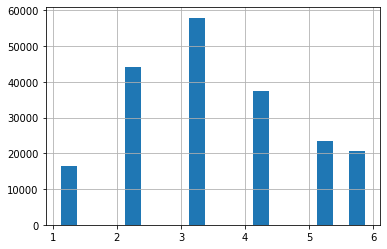

In [226]:
cars["priceGroup"].hist(rwidth=0.5)

In [227]:
cars["priceGroup"].value_counts() / len(cars)

priceGroup
3    0.289680
2    0.221030
4    0.186735
5    0.117580
6    0.103360
1    0.081615
Name: count, dtype: float64

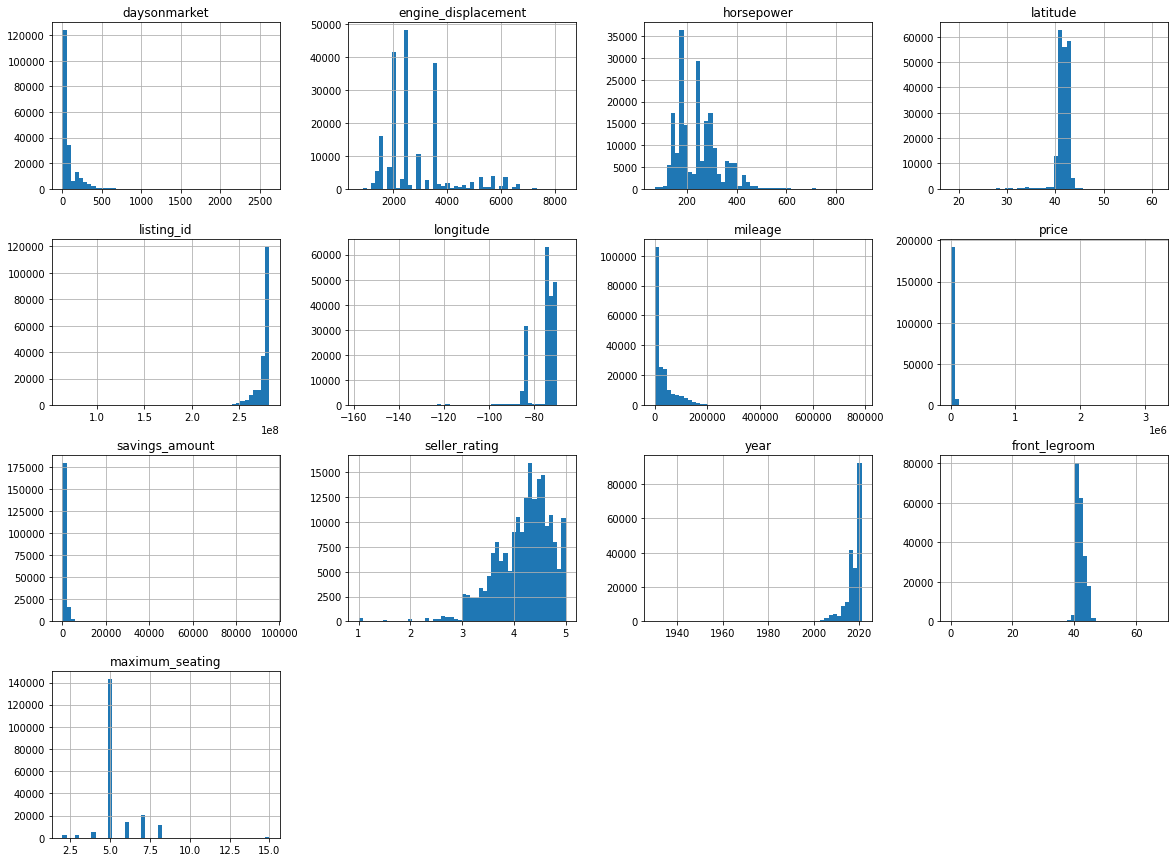

In [228]:
%matplotlib inline
import matplotlib.pyplot as plt

cars.hist(bins=50, figsize=(20,15))
plt.show()

## Set a side a test set, before changing anything on the data structure

In order to ensure that our test set stays consistent no matter how many times we rerun the program or update the dataset, we want to use a unique identifier to help us decide if the row should go into the test set or not. We can compute a hash for each row's unique identifier and if it is less than or equal to 20% of the maximum hash value, it will go into the test set. 

In [229]:
len(cars) - len(cars["listing_id"].unique()) # Making sure "listing_id" is unique

0

In [230]:
from zlib import crc32

def IDTest(ID, testRatio):
    return crc32(np.int64(ID)) & 0xffffffff < testRatio*2**32

def splitTrainTestByID(dataset,testRatio,ID):
    IDs = dataset[ID]
    testRows = IDs.apply(lambda ID_: IDTest(ID_, testRatio))
    return dataset.loc[~testRows], dataset.loc[testRows]

In [231]:
trainSet, testSet = splitTrainTestByID(cars, 0.2, "listing_id")

In [232]:
len(trainSet) / len(cars) # training set should be 80%

0.800635

In [233]:
len(testSet) / len(cars) # training set should be 20%

0.199365

Let's compare our test set's price group proportions to the overall price group proportions.

In [234]:
(testSet["priceGroup"].value_counts() / len(testSet)) - (cars["priceGroup"].value_counts() / len(cars))


priceGroup
3   -0.003246
2    0.000599
4    0.002416
5    0.001272
6    0.000294
1   -0.001335
Name: count, dtype: float64

The proportions of the price groups in our test set are nearly identical to the overall proportions, with the largest difference being 0.32% off. 
Therefore, it is not necessary to try and do stratified sampling. 

We can now be confident that our test set is a good representation of the overall dataset.
We can remove the priceGroup column.

In [235]:
for set_ in (trainSet, testSet):
    set_ = set_.drop("priceGroup", axis=1)

## Visualizing the data

In [236]:
cars = trainSet.copy()

<Axes: xlabel='longitude', ylabel='latitude'>

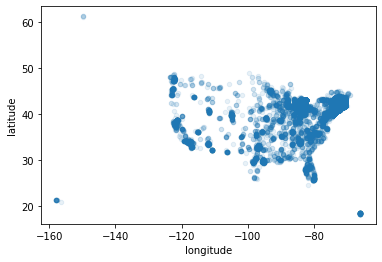

In [237]:
cars.plot.scatter(x="longitude", y="latitude", alpha=0.1)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


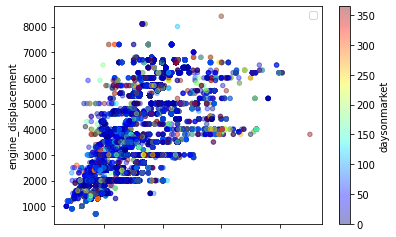

In [238]:
cars.plot.scatter(x="horsepower", y="engine_displacement", alpha=0.4,
                  c="daysonmarket", cmap=plt.get_cmap("jet"), colorbar=True,
                  vmin=0, vmax=365)
plt.legend()